# Рекуррентные сети продолжение

Цели:

- Напомнить про недостатки MLE-подхода и простые способы их исправления
- Разобраться c adversarial-вариантом решения проблемы

Содержание:

* [Teacher forcing](#teacher)
* [Scheduled sampling](#sampling)
* [Professor forcing](#professor)


Ссылки:

1. [Scheduled sampling for sequence prediction with recurrent neural networks, Bengio et al., 2015](https://arxiv.org/pdf/1506.03099.pdf)
2. [How (not) to Train your Generative Model: Scheduled Sampling, Likelihood, Adversary?, Huszar, 2015](https://arxiv.org/pdf/1511.05101.pdf)
3. [Professor Forcing: A New Algorithm for Training Recurrent Networks, NeurIPS 2016](https://papers.neurips.cc/paper_files/paper/2016/file/16026d60ff9b54410b3435b403afd226-Paper.pdf)


<a name="teacher"></a>
## Teacher forcing



RNN декомпозируют распределение дискретной последовательности $y_1, y_2, ... y_T$ на произведение условных вероятностей предыдущих токенов $P(y_1, y_2, ... y_T) = P(y_1)\displaystyle\prod_{t=1}^{T}P(y_t | y_1, ..., y_{t−1})$.

Мы хотим обучить нейросеть с параметрами $\theta$ которая умеет оценивать условные вероятности:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$

Такие модели, когда значение в данный момент зависят от предыдущих значений в последовательности называются авторегрессионными.

Дальше мы подбираем параметры нейросети, для минимизации кроссэнтропии по обучающему датасету $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

Задача минимизации энтропии эквивалентна максимизации правдоподобия (каждого следующего токена при условии предыдущих токенов), поэтому в статьях про генерацию последовательностей рекуррентные сети упоминаются как MLE-модели.

Такой подход к обучению получил название Teacher Forching, так как истинные токены $y_t$ подаются на вход модели в качестве условия для предсказания следующих токенов. Это вынуждает модель оставаться близкой к истинной последовательности.

Однако при генерации истинная последовательность недоступна и мы сэмплируем токены из условного распределения при условии токенов, которые также сгенерированы ранее.

При этом небольшая ошибка на каждом шаге генерации накапливается в бОльшую составную ошибку в посылке, поскольку сгенерированные последовательности отличаются от реальных.

Эта проблема получила название exposure bias.



<a name="sampling"></a>
## Scheduled Sampling

В работе [1] предложили curriculum learning - подход для аккуратного устранения разрыва между обучением и инференсом. В процессе обучения модеиль постепенно вынуждали иметь дело со своими же ошибками, как это обычно происходит в ходе инференса.

Подход заключается в механизме сэмплирования, который случайным образом решает во время обучения - использовать $y_{t-1}$ или $\hat{y}_{t-1}$. Если мы используем стохастический градиентный спуск по мини-батчам, для каждого $i$-го токена в батче, чтобы предсказать $y_t \in Y$ было предложено подбрасывать монетку и использовать истинный токен с вероятностью $ϵ_i$ или сгенерированный с вероятностью $1 - ϵ_i$. При этом предсказанный токен может как сэмплироваться с модельной вероятностью $P(y_{t-1}|h_{t-1})$ так и браться как $\underset{s}{\mathrm{argmax}}\ P(y_{t-1}=s|h_{t-1})$.

Когда $ϵ_i=1$, модель обучается как при классическом процессе обучения, а когда $ϵ_i=0$ - как при инференсе.

Curriculum learning стратегия заключается в неком плане перехода от одной крайности к другой. Интуитивно, в начале процесса обучения сэмплирование из модели выдаёт случайные токены, так как модель ещё не обучена, что может приводить к медленной сходимости, так что более частое сэмплирование реального токена должно помочь. С другой стороны ближе к концу обучения $ϵ_i$ должно обеспечивать более частое сэмплирование из модели, уже в соответствии с ситуацией при инференсе. При этом предполагается что модель уже достаточно хороша, чтобы выдавать разумные токены.

Поэтому предлагается использовать расписание уменьшения $ϵ_i$ как функция от номера итерации, похоже на то, как в современных подходах к стохастическому градиентному спуску уменьшается частота обучения:

* линейное затухание: $ϵ_i=max(ϵ_i, k-ci)$
* экспоненциальное затухание: $ϵ_i=k^i, k<1$
* затухание по обратной сигмоиде: $ϵ_i=k/(k + e^\frac{i}{k}), k>=1$

Подход получил название Scheduled Sampling.

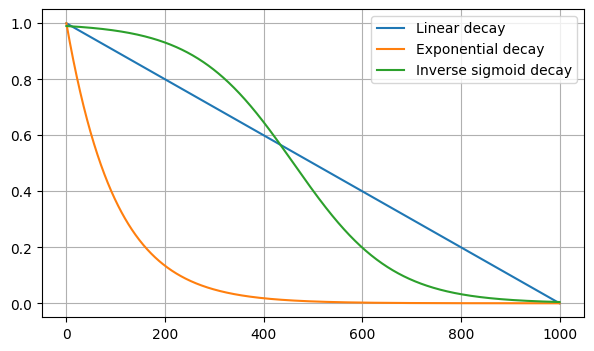

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 4))
x = np.arange(0, 1001)
eps_linear = -0.001*x + 1
eps_exp = 0.99**x
k = 100
eps_inv_sigm = k/(k + np.exp(x/k))
plt.plot(x, eps_linear)
plt.plot(x, eps_exp)
plt.plot(x, eps_inv_sigm)
plt.grid(True)
plt.legend(['Linear decay', 'Exponential decay', 'Inverse sigmoid decay']);

Но подход Scheduled Sampling лечит проблему смещения инференса от обучения лишь симптоматически. Как было показано в [2], это приводит к смещениям, даже в случае когда число примеров бесконечно, процедура может не сойтись к корректной модели.

Однако на практике подход даёт небольшие улучшения в устойчивости сгенерированных последовательностей и как следствие в метриках качества.

[2] интересная теоретическая работа, где показали, что максимум правдоподобия не позволяет решить поставленную задачу и попытались построить идеальную целевую функцию на основе состязательного обучения.
Спустя 8 лет любопытно выглядит фраза:
> We argue that maximum likelihood is an inappropriate training objective when the end-goal is to generate natural-looking samples.

<a name="professor"></a>
## Professor Forcing

Professor Forcing - альтернативный способ обучения рекуррентных сетей, который явно пытается сблизить поведение модели при обучении и инференсе настолько, насколько возможно. Причём устойчивость генерации сохраняется даже на более длинных последовательностях, чем те, которые модель видела при обучении. По словам авторов подход позволяет лучше моделировать протяжённые во времени зависимости используя целевую функцию, которая фокусируется не только на предсказании следующего токена.

Основная идея проста - в то время как мы хотим, чтобы генеративная модель соответствовала обучающим данным, мы также хотим, чтобы поведение модели (входы, выходы и скрытые состояния) были бы не отличимы - как в режиме обучения по реальным последовательностям (teacher forcing), так и в режиме свободной генерации (free running generative). Поскольку для второй цели мы можем сравнить только распределения, почему бы не использовать подходы из GAN'ов.

Вдобавок к генеративной RNN обучается вторая модель - дискриминатор, который тоже является рекуррентной сетью, но уже двунаправленной (Bidirectional RNN), чтобы смотреть вперёд и назад по последовательности.

Генератор генерирует последовательности в двух режимах (обучение и свободная генерация), а дискриминатор получая на вход последовательность выходов и скрытых слоёв оценивает вероятность того, что эта последовательность была получена в режиме обучения по реальным последовательностям.

### Целевая функция

Параметры дискриминатора обучаются максимизировать правдоподобие корректной классификации реальных и сгенерированных последовательностей:

$C_d(θ_d|θ_g)=\mathbb{E}_{y\sim data}[-logD(B(y,θ_g),θ_d)+\mathbb{E}_{y\sim P_{θ_g}(y)}[1-logD(B(y,θ_g),θ_d)]]$,

где функция $B(y,\theta_g)$ выдаёт последовательность входов и скрытых состояний по $y$. Нотация $C_d(θ_d|θ_g)$ обозначает, что при изменении генератора, меняется и дискриминатор.

Параметры генератора $θ_g$ обучаются во-первых максимизации правдоподобия данных, во-вторых обмануть дискриминатор.
То есть вдобавок к логарифму правдоподобия:

$NLL(θ_g)=\mathbb{E}_{y\sim data}[-log P_{θ_g}(y)]$

добавляется лосс, который пытается сблизить поведение при генерации к поведению при обучении, при фиксированном последнем:

$C_f(θ_g|θ_d)=\mathbb{E}_{y\sim P_{θ_g}(y)}[-logD(B(y,θ_g),θ_d)]$.

Вдобавок (опционально), мы можем требовать, чтобы поведение при обучении было неотличимо от поведения при генерации:

$C_t(θ_g|θ_d)=\mathbb{E}_{y\sim data}[-log(1-D(B(y,θ_g),θ_d))]$.

В экспериментах авторов выполнялся градиетный спуск по $NLL + C_f$ или $NLL + C_f + C_t$ для обновления параметров генератора, в то время как для дискриминатора всегда выполнялся градиентный спуск по $C_d$.



Отличие от GAN в том, что дискриминатор пытается отличить скрытые состояния в режиме обучения и инференса, в то время как в классическом GAN разделяются реальные и сгенерированные образцы. Это даёт преимущество того, что можно учить генеративную модель над распределением дискретных случайных величин, без требования аппроксимации обратного распространения ошибки через дискретные пространства.

## Попытка реализации

Borrowed from https://github.com/mojesty/professor_forcing

In [ ]:
import time
import math
import torch
import random
import string
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode2ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

<a name="load_data"></a>
### Загрузка данных

In [ ]:
all_letters = string.ascii_letters + "1234567890" + " .,;'\n"
n_letters = len(all_letters)

In [ ]:
# Alternative manual download link: https://yadi.sk/d/_nGyU2IajjR9-w
# !wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!wget https://huggingface.co/datasets/sswt/arxiv_sample_50K/resolve/main/arxiv_sample.tar.gz -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz

--2023-10-04 09:37:46--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz [following]
--2023-10-04 09:37:46--  https://www.dropbox.com/s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc08e5dbaa323ce53b4c6a77df14.dl.dropboxusercontent.com/cd/0/get/CE-8TYe8IBkX7UvwKxnNPyw0NfQPuLZfbaVEDNj327yru67JO3ZFQPyXaiuWZ0XHSvbvDmbVVKuZCtEVmeN073nxQqm34W9-v3EHCqXDEUWT0Zg6LDMM9_Gqk04muzFFBqY/file?dl=1# [following]
--2023-10-04 09:37:47--  https://uc08e5dbaa323ce53b4c6a77df14.dl.dropboxusercontent.com/cd/0/get/CE-8TYe8IBkX7UvwKxnNPyw0NfQPuLZfbaVEDNj327yru67JO3ZFQPyXaiuWZ0XHSvbvDmbVVKuZCtEVmeN073nxQqm34W

In [ ]:
data = pd.read_json("./arxivData.json")
print(data.shape)
data.sample(n=3)

(41000, 9)


,author,day,id,link,month,summary,tag,title,year
25204,"[{'name': 'Tiep Huu Vu'}, {'name': 'Hojjat Sey...",16,1506.05032v5,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",6,"In histopathological image analysis, feature e...","[{'term': 'cs.CV', 'scheme': 'http://arxiv.org...",Histopathological Image Classification using D...,2015
22566,"[{'name': 'Leila Wehbe'}, {'name': 'Anwar Nune...",6,1701.01437v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",1,This workshop explores the interface between c...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",NIPS 2016 Workshop on Representation Learning ...,2017
2562,"[{'name': 'Purushottam Kar'}, {'name': 'Shuai ...",13,1605.04135v3,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",5,"The estimation of class prevalence, i.e., the ...","[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Online Optimization Methods for the Quantifica...,2016


In [ ]:
seq_len = 256  # to prevent RNN gradients from exploding
BOS, EOS = ' ', '\n'

# + EOS
lines = data.apply(lambda row: unicode2ascii((row['title'] + ' ; ' + row['summary'])[:seq_len]), axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ')) \
            .tolist()

In [ ]:
data['summary'].apply(lambda x: len(x)).describe()

count    41000.000000
mean      1023.248098
std        358.009525
min         25.000000
25%        770.000000
50%        999.500000
75%       1253.250000
max       3658.000000
Name: summary, dtype: float64

In [ ]:
lines[:3]

[' Dual Recurrent Attention Units for Visual Question Answering ; We propose an architecture for VQA which utilizes recurrent layers to generate visual and textual attention. The memory characteristic of the proposed recurrent attention units offers a rich jo',
 ' Sequential ShortText Classification with Recurrent and Convolutional   Neural Networks ; Recent approaches based on artificial neural networks ANNs have shown promising results for shorttext classification. However, many short texts occur in sequences ',
 ' Multiresolution Recurrent Neural Networks An Application to Dialogue   Response Generation ; We introduce the multiresolution recurrent neural network, which extends the sequencetosequence framework to model natural language generation as two parallel d']

### Реализация

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Generator(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, device=None):
        super(Generator, self).__init__()
        self.device = device
        self.input_size = vocab_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.GRUCell(embedding_size, hidden_size)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, word_inputs, hidden):
        # word_inputs                                       [batch_size x 1]
        # hidden                                            [batch_size x hidden_size]
        seq_len, batch_size = word_inputs.size(1), word_inputs.size(0)
        # embedding layer requires word_input of shape [N x W]
        embedded = self.embedding(word_inputs).view(batch_size, -1)  # [batch_size x emb_size]
        next_hidden = self.rnn(embedded, hidden)          # [batch_size x hidden_size]
        unnormalized_scores = self.linear(next_hidden)    # [batch_size x vocab_size]
        # scores = F.softmax(unnormalized_scores, dim=1)  # [batch_size x vocab_size]
        return unnormalized_scores, next_hidden

    def consume(self, word_input, hidden, sampling,
                method='multinomial', temperature=3, n_sampled=None):
        # word_inputs                                       [batch_size x seq_len]
        # hidden                                            [batch_size x hidden_size]
        # store all hidden states for discriminator
        hidden_states = [hidden]
        word_inputs = [word_input.data]
        seq_len, batch_size = word_input.size(1), word_input.size(0)
        if n_sampled: seq_len = n_sampled
        criterion = nn.CrossEntropyLoss()
        loss = 0
        if sampling:
            # autoregressive mode
            # we need only initial word inputs
            current_word_inputs = word_input[:, 1].unsqueeze(1)
            for idx in range(seq_len - 1):
                scores, hidden = self(current_word_inputs, hidden)
                if not n_sampled: loss += criterion(scores, word_input[:, idx + 1])
                hidden_states.append(hidden)
                current_word_inputs = self._sample(scores, method, temperature)
                word_inputs.append(current_word_inputs.data)

        else:
            # teacher forcing mode
            for idx in range(seq_len - 1):
                scores, hidden = self(word_input[:, idx].unsqueeze(1), hidden)
                loss += criterion(scores, word_input[:, idx + 1])
                hidden_states.append(hidden)

        # we still can't go backward because we another losses are not computed
        hidden_states = torch.stack(hidden_states, dim=1)
        # word_inputs = torch.stack(word_inputs, dim=1)
        return loss, hidden_states, word_inputs

    def _sample(self, scores, method, temperature):
        # scores                                            [batch_size x vocab_size]
        # method                                            cfg.sample_methods
        scores = F.softmax(scores, dim=1)
        if method == 'argmax':
            # find elements with max values for each score list in the minibatch
            topv, topi = scores.data.topk(1, dim=1)       # [batch_size x 1]
        elif method == 'multinomial':
            _scores = scores.cpu().div(temperature).exp().data
            topi = torch.multinomial(_scores, 1)          # [batch_size x 1]
        topi = topi.to(self.device)
        return topi

    def init_hidden(self, batch_size, strategy='zeros'):
        if strategy == 'zeros':
            hidden = torch.zeros(batch_size, self.hidden_size)
        elif strategy == 'xavier':
            hidden = torch.zeros(batch_size, self.hidden_size)
            hidden = torch.nn.init.xavier_normal_(hidden)
        hidden = hidden.to(self.device)
        return hidden

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, linear_size, lin_dropout, device):
        super(Discriminator, self).__init__()

        self.hidden_size = hidden_size
        self.linear_size = linear_size
        self.device = device
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.linears = nn.Sequential(
            nn.Linear(hidden_size * 2, linear_size),
            nn.ReLU(),
            nn.Dropout(lin_dropout),
            nn.Linear(linear_size, linear_size),
            nn.ReLU(),
            nn.Dropout(lin_dropout),
            nn.Linear(linear_size, 1)
        )

    def forward(self, hidden_states):
        # hidden_states                                           # [batch_size * seq_len * hid_size]
        batch_size = hidden_states.size(0)
        initial_hidden = self.init_hidden(hidden_states.size(0))
        _, rnn_final_hidden = self.rnn(
            hidden_states, initial_hidden)                        # [2 * batch_size * hid_size]
        rnn_final_hidden = rnn_final_hidden.view(batch_size, -1)  # [batch_size * (2 * hidden_size)]
        scores = self.linears(rnn_final_hidden)                   # [batch_size * 1]
        scores = F.sigmoid(scores)          # [batch_size * 1]
        return scores

    def init_hidden(self, batch_size):
        hidden = torch.zeros(2, batch_size, self.hidden_size).to(self.device)
        return hidden

In [ ]:
class PF(nn.Module):

    def __init__(self, opt):
        super(PF, self).__init__()
        self.opt = opt
        self.generator = Generator(
            opt.vocab_size,
            opt.embedding_size,
            opt.hidden_size,
            opt.device
        )
        self.discriminator = Discriminator(
            opt.hidden_size,
            opt.d_hidden_size,
            opt.d_linear_size,
            opt.d_dropout,
            opt.device
        ) if opt.adversarial else None

    def forward(self, input, adversarial=True):
        batch_size = input.size(0)
        if not adversarial:
            # vanilla Negative log-likelihood training, no sampling
            start_hidden = self.generator.init_hidden(batch_size, strategy='zeros')

            loss, gen_hidden_states, _ = self.generator.consume(input, start_hidden, sampling=False)

            return loss, None, None, None, None
        else:
            # run one pass without sampling
            start_hidden_nll = self.generator.init_hidden(batch_size, strategy='zeros')
            loss_nll, gen_hidden_states_nll, _ = self.generator.consume(
                input, start_hidden_nll, sampling=False)

            # run one pass with sampling
            start_hidden_adv = self.generator.init_hidden(batch_size, strategy='zeros')
            loss_adv, gen_hidden_states_adv, _ = self.generator.consume(
                input,
                start_hidden_adv,
                sampling=True,
                method=self.opt.sampling_strategy,
                temperature=self.opt.temperature
            )
            # these two passes have computational graphs that are completely different, so
            # in the future we can call backwards for each loss consequently

            # Now, call the discriminator
            teacher_forcing_scores = self.discriminator(gen_hidden_states_nll)
            autoregressive_scores = self.discriminator(gen_hidden_states_adv)

            return loss_nll + loss_adv, teacher_forcing_scores, autoregressive_scores,\
        gen_hidden_states_nll, gen_hidden_states_adv

    def view_rnn_grad_norms(self):
        norms_dict = {
            k: v.grad.norm().item()
            for k, v in self.named_parameters()
            if 'rnn' in k
        }
        return norms_dict

In [ ]:
class Trainer:
    def __init__(self, opt, model):
        self.opt = opt
        self.model = model
        self.g_optim = torch.optim.Adam(model.generator.parameters(), lr=opt.learning_rate)
        if opt.adversarial:
            self.d_optim = torch.optim.Adam(model.discriminator.parameters(), lr=opt.learning_rate)

    def train(self, opt, input):

        self.model.zero_grad()
        # is_* means Intermediate State, we will need them to detach history if discriminator
        # is too poor
        nll_loss, tf_scores, ar_scores, is_nll, is_adv = self.model(
            input, adversarial=self.opt.adversarial)
        # Backpropagation
        nll_loss.backward(retain_graph=True)
        if self.opt.adversarial:
            update_g, update_d = self._need_update(tf_scores, ar_scores)
            g_loss = self._calculate_generator_loss(tf_scores, ar_scores).sum()
            d_loss = self._calcualte_discriminator_loss(tf_scores, ar_scores).sum()
            if not update_g:
                is_nll = is_nll.detach()
                is_adv = is_adv.detach()
            d_loss.backward(retain_graph=True)
            g_loss.backward()
            g_loss_value = g_loss.item()
            d_loss_value = d_loss.item()
        else:
            g_loss_value = None
            d_loss_value = None
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.opt.clip)

        self.g_optim.step()#  and (not self.opt.adversarial or self.d_optim.step())
        if self.opt.adversarial and update_d:
            self.d_optim.step()

        return nll_loss.cpu().item(), g_loss_value, d_loss_value

    def _calculate_generator_loss(self, tf_scores, ar_scores):
        """
        Calculates Fool-The-Discriminator loss
        Optionally calculate the reverse loss
        :param tf_scores: Teacher Forcing scores
        :param ar_scores: AutoRegressive scores
        :return:
        """
        loss = torch.log(ar_scores) * (-1)

        if self.opt.optional_loss:
            loss += torch.log(1 - tf_scores) * (-1)
        return loss

    def _calcualte_discriminator_loss(self, tf_scores, ar_scores):
        tf_loss = torch.log(tf_scores) * (-1)
        ar_loss = torch.log(1 - ar_scores) * (-1)
        return tf_loss + ar_loss

    def _need_update(self, tf_scores, ar_scores):
        """
        Discriminator accuracy < 0.75 --> don't backpropagate to generator
        Discriminator accuracy > 0.99 --> don't train discriminator
        Discriminator guess is calculated as x > 0.5
        :param tf_scores: Teacher Forcing scores [batch_size * 1]
        :param ar_scores: AutoRegressive scores  [batch_size * 1]
        :return:
        """
        correct = float((tf_scores.view(-1) > 0.5).sum() + (ar_scores.view(-1) < 0.5).sum())
        d_accuracy = correct / (tf_scores.size(0) * 2)
        if d_accuracy < 0.75:
            return False, True
        elif d_accuracy > 0.99:
            return True, False
        else:
            return True, True

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ArxivDataset(Dataset):
    def __init__(self, texts, vocab, max_len=256):
        self.texts = texts
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.to_tensor(self.texts[idx])

    def to_tensor(self, line):
        t = torch.LongTensor([self.vocab.find(line[li]) for li in range(len(line[:self.max_len]))])
        if len(line) < self.max_len:
            t = nn.ConstantPad1d((0, self.max_len - len(line)), 0)(t)
        return t

In [ ]:
from collections import namedtuple

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

### Цикл обучения

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

In [ ]:
model_conf = {
    'embedding_size': 32,
    'hidden_size': 1024,
    'vocab_size': n_letters,
    'temperature': 0.9,
    'd_hidden_size': 512,
    'd_linear_size': 512,
    'd_dropout': 0.2,
    'sampling_strategy': 'multinomial',  # TODO: Get rid of this
    'adversarial': True,
    'device': device
}
model_conf = namedtuple('Struct', model_conf)(**model_conf)

In [ ]:
model = PF(model_conf)
model.to(device)

PF(
  (generator): Generator(
    (embedding): Embedding(68, 32)
    (rnn): GRUCell(32, 1024)
    (linear): Linear(in_features=1024, out_features=68, bias=True)
  )
  (discriminator): Discriminator(
    (rnn): GRU(1024, 512, batch_first=True, bidirectional=True)
    (linears): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=512, out_features=1, bias=True)
    )
  )
)

In [ ]:
train_conf = {
    'batch_size': 128,
    'adversarial': True,  # Use Professor Forcing or vanilla NLL
    'optional_loss': True,  # Optional loss for generator
    'bptt': 20,  # How many steps to backpropagate
    'learning_rate': 0.001,  # Learning rate
    'clip': 2.0,  # Clip gradients if their l2 norm above threshold
    'n_epochs': 5,  # Total training epochs
    'print_every': 20,  # Print info in stdout every N batches
    'seed': 42,  # Random seed for reproducible results
    'plot_every': 200,  # Add data every N batches
    'n_instances': 300
}
train_conf = namedtuple('Struct', train_conf)(**train_conf)

In [ ]:
trainer = Trainer(train_conf, model)

In [ ]:
data = ArxivDataset(lines, all_letters)
dl = DataLoader(data, batch_size=32, shuffle=True)

In [ ]:
start = time.time()
losses = []
print_nll_loss_total = 0  # Reset every print_every
print_g_loss_total = 0
print_d_loss_total = 0
plot_loss_total = 0  # Reset every plot_every

for epoch in range(1, train_conf.n_epochs + 1):
    for idx, batch in enumerate(dl):
        nll_loss, gen_loss, disc_loss = trainer.train(train_conf, batch.to(device))
        if idx % train_conf.print_every == 0:
            losses.append(nll_loss)
        # Keep track of loss
        print_nll_loss_total += nll_loss
        if train_conf.adversarial:
            print_g_loss_total += gen_loss
            print_d_loss_total += disc_loss
            plot_loss_total += nll_loss

        if epoch == 0: continue

        if idx % train_conf.print_every == 0:
            print_summary = '%s (%d %d%%) nll %.4f generator %.4f discriminator %.4f' % (
                time_since(start, epoch / train_conf.n_epochs),
                epoch,
                epoch / train_conf.n_epochs * 100,
                print_nll_loss_total / (train_conf.print_every if idx > 0 else 1),
                print_g_loss_total / (train_conf.print_every if idx > 0 else 1),
                print_d_loss_total / (train_conf.print_every if idx > 0 else 1),
            )
            print(print_summary)
            print_nll_loss_total = 0
            print_g_loss_total = 0
            print_d_loss_total = 0

        if train_conf.n_instances and idx > train_conf.n_instances:
            break

0m 1s (- 0m 5s) (1 20%) nll 2155.0471 generator 44.3736 discriminator 44.3529
0m 25s (- 1m 41s) (1 20%) nll 1750.9553 generator 44.4511 discriminator 44.3699
0m 48s (- 3m 14s) (1 20%) nll 1541.8090 generator 44.3635 discriminator 44.3609
1m 11s (- 4m 45s) (1 20%) nll 1507.9519 generator 44.3620 discriminator 44.3614
1m 34s (- 6m 19s) (1 20%) nll 1483.0887 generator 44.3668 discriminator 44.3563
1m 58s (- 7m 53s) (1 20%) nll 1459.6277 generator 44.3607 discriminator 44.3624
2m 21s (- 9m 26s) (1 20%) nll 1422.5690 generator 44.3638 discriminator 44.3592
2m 44s (- 10m 59s) (1 20%) nll 1387.1586 generator 44.3639 discriminator 44.3591
3m 8s (- 12m 32s) (1 20%) nll 1356.7911 generator 44.3628 discriminator 44.3602
3m 31s (- 14m 5s) (1 20%) nll 1329.4177 generator 44.3589 discriminator 44.3640
3m 54s (- 15m 38s) (1 20%) nll 1302.4025 generator 44.3607 discriminator 44.3622
4m 17s (- 17m 11s) (1 20%) nll 1275.4888 generator 44.3626 discriminator 44.3603
4m 41s (- 18m 44s) (1 20%) nll 1257.191

### Генерация

In [ ]:
def raw_input(batch_size, vocab_size):
    l = [0] * vocab_size
    # l[20] = 1
    return torch.LongTensor(l).to(device).repeat((batch_size, 1))

In [ ]:
model.eval()

PF(
  (generator): Generator(
    (embedding): Embedding(68, 32)
    (rnn): GRUCell(32, 1024)
    (linear): Linear(in_features=1024, out_features=68, bias=True)
  )
  (discriminator): Discriminator(
    (rnn): GRU(1024, 512, batch_first=True, bidirectional=True)
    (linears): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=512, out_features=1, bias=True)
    )
  )
)

In [ ]:
num_samples = 3
start_hidden = model.generator.init_hidden(num_samples).to(device)
inp = raw_input(num_samples, n_letters)

In [ ]:
_, hidden_states, words_indices = model.generator.consume(
    inp, start_hidden, sampling=True, method='multinomial', temperature=30)
words_indices = torch.stack(words_indices[1:], dim=1).cpu()

In [ ]:
for idx in range(num_samples):
    tokens = [data.vocab[idx[0].item()] for idx in words_indices[idx, :]]
    print(''.join(tokens), end='<EOS>\n')

K
608kh;F,JakJrsOlLc5xV'UGksc0hTlcxIMlZKcLEuOuctOsdvaKxmhl9Z

BIWpu<EOS>
TB3bW tdng5y;mc'TW5w;njd,rcQtMofxi9nfkkOI
q4OgjGNK;K24ewQWS
;bGUrcl<EOS>
SqI5kPgDj zHr4FZIBlxxNSGGiLX5'iHAD
MWE FVDq6.UWsSJFEc8N6hLwBxa36xfJ<EOS>


In [ ]:
num_samples = 2
start_hidden = model.generator.init_hidden(num_samples).to(device)
inp = raw_input(num_samples, n_letters)

In [ ]:
_, hidden_states, words_indices = model.generator.consume(
    inp, start_hidden, sampling=True, method='argmax', temperature=.5)
words_indices = torch.stack(words_indices[1:], dim=1).cpu()

In [ ]:
for idx in range(num_samples):
    tokens = [data.vocab[idx[0].item()] for idx in words_indices[idx, :]]
    print(''.join(tokens), end='<EOS>\n')

deent seecenteceetetetetetet steceetetetetetetetterttettertataaaaaa<EOS>
deent seecenteceetetetetetet steceetetetetetetetterttettertataaaaaa<EOS>
